In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Import our not-MIWAE implementation
from notmiwae_pytorch import NotMIWAE, MIWAE, Trainer, BaseMissingProcess
from notmiwae_pytorch.utils import (
    set_seed, 
    imputation_rmse,
    standardize,
)
from typing import Optional, Literal, Union
import torch.nn as nn 
import torch.nn.functional as F
# Set random seed for reproducibility
set_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Load the Wine Quality dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = pd.read_csv(url, sep=';')

print(f"Dataset shape: {data.shape}")
print(f"\nColumn names: {list(data.columns)}")
print(f"\nFirst few rows:")
data.head()

Dataset shape: (4898, 12)

Column names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

First few rows:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
# Drop the quality column (target) - we only want features
X = data.drop('quality', axis=1).values.astype(np.float32)
N, D = X.shape

print(f"Data shape: N={N} samples, D={D} features")

# No standardization - use raw data
X_std = X  # Keep variable name for compatibility

# Random permutation
perm = np.random.permutation(N)
X_std = X_std[perm]

print(f"\nData statistics:")
print(f"Mean: {X_std.mean(axis=0).round(4)}")
print(f"Std: {X_std.std(axis=0).round(4)}")

Data shape: N=4898 samples, D=11 features

Data statistics after standardization:
Mean: [-0.  0.  0. -0.  0. -0. -0. -0.  0. -0. -0.]
Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 2. Introduce Missing Values (MNAR Mechanism)

Following the paper's experimental setup, we introduce **self-masking MNAR**:
- In the first D/2 dimensions, values above the mean are missing
- This creates a challenging scenario where the missingness depends on the values themselves

In [ ]:
def introduce_sinusoidal_mnar(X, amplitude=1.0, frequency=1.0, phase=0.0, base_prob=0.3, seed=42):
    """
    Introduce MNAR missing values with a sinusoidal pattern.
    
    The probability of missingness follows a sinusoidal function of the feature value:
        p(missing | x) = base_prob + (1 - base_prob) * 0.5 * (1 + sin(frequency * x + phase))
    
    This creates a cyclic pattern where certain value ranges are more likely to be missing,
    simulating scenarios like:
    - Periodic sensor failures at certain value ranges
    - Cyclical censoring in time-series data
    - Non-monotonic reporting patterns
    
    Args:
        X: Data array (N, D)
        amplitude: Controls the strength of the sinusoidal effect (0 to 1)
        frequency: Controls how many "cycles" of missingness across the value range
        phase: Phase shift of the sinusoid (per feature or single value)
        base_prob: Baseline probability of missingness
        seed: Random seed
    
    Returns:
        X_nan: Data with NaN for missing values
        X_filled: Data with missing values filled with 0
        mask: Binary mask (1=observed, 0=missing)
        params: Dict with the parameters used
    """
    np.random.seed(seed)
    N, D = X.shape
    
    # Handle phase: can be single value or per-feature
    if np.isscalar(phase):
        phases = np.full(D, phase)
    else:
        phases = np.array(phase)
    
    # Handle frequency: can be single value or per-feature
    if np.isscalar(frequency):
        frequencies = np.full(D, frequency)
    else:
        frequencies = np.array(frequency)
    
    # Initialize mask (all observed)
    mask = np.ones_like(X)
    
    # For each feature, compute missingness probability based on sinusoidal pattern
    for d in range(D):
        # Sinusoidal probability: oscillates between base_prob and 1.0
        # sin output is in [-1, 1], we map to [0, 1] then scale by amplitude
        sin_component = np.sin(frequencies[d] * X[:, d] + phases[d])
        # Map from [-1, 1] to [0, 1]
        sin_normalized = 0.5 * (1 + sin_component)
        # Scale by amplitude and add base probability
        prob_missing = base_prob + amplitude * (1 - base_prob) * sin_normalized
        
        # Sample from Bernoulli
        missing_indicators = np.random.binomial(1, prob_missing, size=N)
        mask[:, d] = 1 - missing_indicators
    
    # Create versions with missing values
    X_nan = X.copy()
    X_nan[mask == 0] = np.nan
    
    # Fill missing values with column mean
    X_filled = X.copy()
    for d in range(D):
        col_mean = X[mask[:, d] == 1, d].mean()  # Mean of observed values only
        X_filled[mask[:, d] == 0, d] = col_mean
    
    params = {
        'amplitude': amplitude,
        'frequencies': frequencies,
        'phases': phases,
        'base_prob': base_prob
    }
    
    return X_nan, X_filled, mask, params


class SinusoidalMissingProcess(BaseMissingProcess):
    """
    Sinusoidal missing process matching the data generation mechanism:
    
    p(missing | x) = base + amplitude * (1 - base) * 0.5 * (1 + sin(frequency * x + phase))
    p(s=1|x) = 1 - p(missing|x)  [s=1 means observed]
    
    This directly models the known sinusoidal MNAR mechanism, making it more
    intuitive and interpretable.
    
    Args:
        input_dim: Number of features
        init_base: Initial baseline missing probability, scalar or array of shape (input_dim,).
                   Default: 0.3. Should be in [0, 1].
        init_amplitude: Initial amplitude, scalar or array of shape (input_dim,).
                       Default: 1.0. Should be in [0, 1].
        init_frequency: Initial frequency, scalar or array of shape (input_dim,). 
                       Default: 1.0. Should be positive.
        init_phase: Initial phase, scalar or array of shape (input_dim,).
                   Default: 0.0. Can be any value.
        learn_base: Whether to learn base probability (default: True)
        learn_amplitude: Whether to learn amplitude (default: True)
        learn_frequency: Whether to learn frequency (default: True)
        learn_phase: Whether to learn phase (default: True)
        feature_names: Optional list of feature names
    """
    
    def __init__(
        self, 
        input_dim: int, 
        init_base: Union[float, np.ndarray, list] = 0.3,
        init_amplitude: Union[float, np.ndarray, list] = 1.0,
        init_frequency: Union[float, np.ndarray, list] = 1.0,
        init_phase: Union[float, np.ndarray, list] = 0.0,
        learn_base: bool = True,
        learn_amplitude: bool = True,
        learn_frequency: bool = True,
        learn_phase: bool = True,
        feature_names: Optional[list] = None,
        **kwargs
    ):
        super().__init__(input_dim, feature_names, **kwargs)
        
        self.learn_base = learn_base
        self.learn_amplitude = learn_amplitude
        self.learn_frequency = learn_frequency
        self.learn_phase = learn_phase
        
        # Helper function to convert scalar/list/array to tensor
        def _to_tensor(value, name):
            if isinstance(value, (list, np.ndarray)):
                arr = np.array(value)
                if arr.shape != (input_dim,):
                    raise ValueError(f"{name} must be scalar or array of shape ({input_dim},), got {arr.shape}")
                return torch.tensor(arr, dtype=torch.float32).view(1, 1, input_dim)
            else:
                # Scalar
                return torch.full((1, 1, input_dim), float(value))
        
        # Base probability (will be constrained to [0,1] via sigmoid)
        init_base_tensor = _to_tensor(init_base, "init_base")
        # Store as logit for unconstrained optimization
        init_base_logit = torch.logit(torch.clamp(init_base_tensor, 1e-6, 1-1e-6))
        if learn_base:
            self.base_logit = nn.Parameter(init_base_logit)
        else:
            self.register_buffer('base_logit', init_base_logit)
        
        # Amplitude (will be constrained to [0,1] via sigmoid)
        init_amp_tensor = _to_tensor(init_amplitude, "init_amplitude")
        # Store as logit for unconstrained optimization
        init_amp_logit = torch.logit(torch.clamp(init_amp_tensor, 1e-6, 1-1e-6))
        if learn_amplitude:
            self.amplitude_logit = nn.Parameter(init_amp_logit)
        else:
            self.register_buffer('amplitude_logit', init_amp_logit)
        
        # Frequency (will be constrained to positive via softplus)
        init_freq_tensor = _to_tensor(init_frequency, "init_frequency")
        # Store inverse softplus for unconstrained optimization
        # Use numerically stable inverse: softplus^{-1}(y) = log(exp(y) - 1)
        # For stability, use torch.expm1 which computes exp(x) - 1 accurately for small x
        init_freq_raw = torch.log(torch.expm1(torch.clamp(init_freq_tensor, min=1e-6)))
        if learn_frequency:
            self.frequency_raw = nn.Parameter(init_freq_raw)
        else:
            self.register_buffer('frequency_raw', init_freq_raw)
        
        # Phase (unconstrained)
        init_phase_tensor = _to_tensor(init_phase, "init_phase")
        if learn_phase:
            self.phase = nn.Parameter(init_phase_tensor)
        else:
            self.register_buffer('phase', init_phase_tensor)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute logits for p(s=1|x) where s=1 means observed.
        
        Formula:
            p_missing = base + amplitude * (1 - base) * 0.5 * (1 + sin(frequency * x + phase))
            p_observed = 1 - p_missing
            logits = logit(p_observed)
        """
        # Get parameters with constraints
        base = torch.sigmoid(self.base_logit)  # [0, 1]
        amplitude = torch.sigmoid(self.amplitude_logit)  # [0, 1]
        freq = F.softplus(self.frequency_raw)  # positive
        phase = self.phase  # unconstrained
        
        # Compute probability of missing
        sin_component = torch.sin(freq * x + phase)
        p_missing = base + amplitude * (1 - base) * 0.5 * (1 + sin_component)
        
        # Probability of observed (s=1)
        p_observed = 1 - p_missing
        
        # Convert to logits with numerical stability
        p_observed = torch.clamp(p_observed, 1e-7, 1 - 1e-7)
        logits = torch.logit(p_observed)
        
        return logits
    
    def interpret(self, verbose: bool = True) -> dict:
        """Interpret the learned sinusoidal missing process parameters."""
        base = torch.sigmoid(self.base_logit).detach().squeeze().cpu().numpy()
        amplitude = torch.sigmoid(self.amplitude_logit).detach().squeeze().cpu().numpy()
        freq = F.softplus(self.frequency_raw).detach().squeeze().cpu().numpy()
        phase = self.phase.detach().squeeze().cpu().numpy()
        
        results = {
            'process_type': 'sinusoidal',
            'feature_names': self.feature_names,
            'base_prob': base,
            'amplitude': amplitude,
            'frequency': freq,
            'phase': phase,
            'learn_base': self.learn_base,
            'learn_amplitude': self.learn_amplitude,
            'learn_frequency': self.learn_frequency,
            'learn_phase': self.learn_phase,
            'interpretations': []
        }
        
        if verbose:
            print("Sinusoidal Missing Process: p(missing|x) = b + A*(1-b)*0.5*(1 + sin(f*x + φ))")
            print("=" * 70)
            learn_str = []
            if not self.learn_base:
                learn_str.append("base=fixed")
            if not self.learn_amplitude:
                learn_str.append("amplitude=fixed")
            if not self.learn_frequency:
                learn_str.append("frequency=fixed")
            if not self.learn_phase:
                learn_str.append("phase=fixed")
            if learn_str:
                print(f"Fixed parameters: {', '.join(learn_str)}")
        
        for i in range(self.input_dim):
            name = self.feature_names[i]
            
            # Compute period in data units
            period = 2 * np.pi / freq[i] if freq[i] > 0.01 else float('inf')
            
            # Max missing probability occurs when sin = 1
            max_missing_prob = base[i] + amplitude[i] * (1 - base[i]) * 0.5 * (1 + 1)
            # Min missing probability occurs when sin = -1
            min_missing_prob = base[i] + amplitude[i] * (1 - base[i]) * 0.5 * (1 - 1)
            
            # Peak missing at sin(f*x + φ) = 1 => f*x + φ = π/2 + 2πk
            peak_missing_x = (np.pi/2 - phase[i]) / freq[i] if freq[i] > 0.01 else 0
            # Peak observed at sin(f*x + φ) = -1 => f*x + φ = -π/2 + 2πk
            peak_observed_x = (-np.pi/2 - phase[i]) / freq[i] if freq[i] > 0.01 else 0
            
            interp = {
                'feature': name,
                'base_prob': float(base[i]),
                'amplitude': float(amplitude[i]),
                'frequency': float(freq[i]),
                'phase': float(phase[i]),
                'period': float(period),
                'max_missing_prob': float(max_missing_prob),
                'min_missing_prob': float(min_missing_prob),
                'peak_missing_x': float(peak_missing_x),
                'peak_observed_x': float(peak_observed_x)
            }
            results['interpretations'].append(interp)
            
            if verbose:
                print(f"\n{name}:")
                print(f"  Base: {base[i]:.3f}, Amplitude: {amplitude[i]:.3f}, Frequency: {freq[i]:.3f}, Phase: {phase[i]:.3f}")
                print(f"  Period: {period:.3f}")
                print(f"  Missing rate range: [{min_missing_prob:.1%}, {max_missing_prob:.1%}]")
                print(f"  Peak MISSING at x ≈ {peak_missing_x:.2f}")
                print(f"  Peak OBSERVED at x ≈ {peak_observed_x:.2f}")
        
        return results
    
    def plot_missing_probability(self, feature_idx: int = 0, x_range: tuple = (-3, 3), ax=None):
        """
        Plot the learned missing probability curve for a feature.
        
        Args:
            feature_idx: Which feature to plot
            x_range: Range of x values to plot
            ax: Matplotlib axis (creates new figure if None)
        """
        import matplotlib.pyplot as plt
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 4))
        
        x = torch.linspace(x_range[0], x_range[1], 500).view(-1, 1, 1)
        x_expanded = x.expand(-1, 1, self.input_dim)
        
        with torch.no_grad():
            logits = self.forward(x_expanded)
            prob_observed = torch.sigmoid(logits[:, 0, feature_idx])
            prob_missing = 1 - prob_observed
        
        ax.plot(x.squeeze().numpy(), prob_observed.numpy(), 'g-', label='P(observed)', linewidth=2)
        ax.plot(x.squeeze().numpy(), prob_missing.numpy(), 'r--', label='P(missing)', linewidth=2)
        ax.set_xlabel('Feature Value')
        ax.set_ylabel('Probability')
        ax.set_title(f'Sinusoidal Missing Pattern: {self.feature_names[feature_idx]}')
        ax.legend()
        ax.grid(True, alpha=0.3)

        ax.set_ylim(0, 1)        
        return ax
        

## Sinusoidal MNAR Pattern Demo

The sinusoidal missing process creates a **non-monotonic** relationship between values and missingness. Unlike self-masking (where larger values are more/less likely missing), sinusoidal patterns create **periodic** missingness - certain value ranges are more likely missing, then less likely, then more likely again.

Real-world examples:
- Temperature sensors that fail in certain temperature bands
- Survey responses where people avoid reporting values in specific ranges
- Cyclical censoring in time-series data

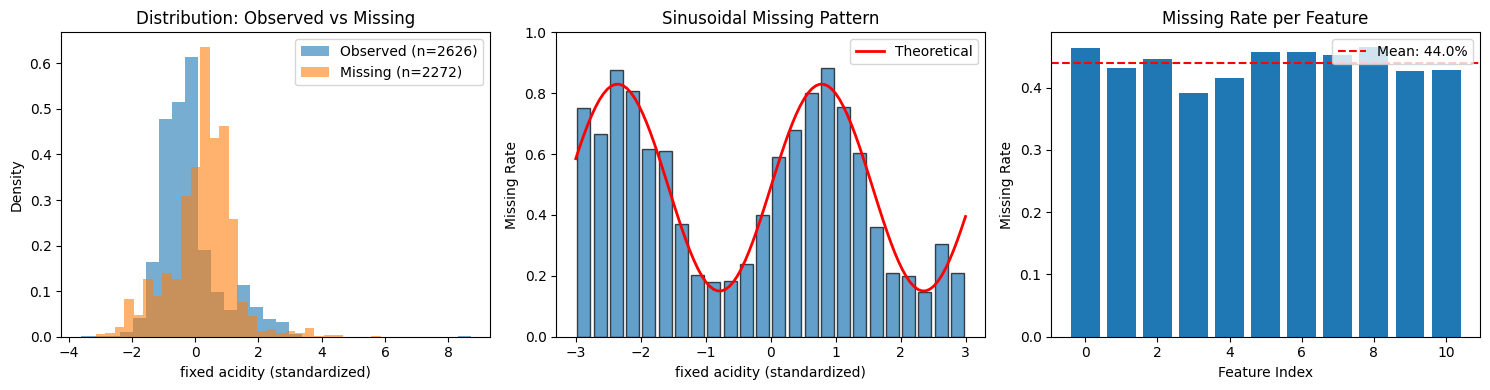


Overall missing rate: 44.0%
Sinusoidal parameters: amplitude=0.8, frequency=2.00


In [ ]:
# Generate data with sinusoidal MNAR pattern
X_nan_sin, X_filled_sin, mask_sin, sin_params = introduce_sinusoidal_mnar(
    X_std, 
    amplitude=0.8,      # Strong sinusoidal effect
    frequency=2.0,      # ~3 "cycles" across value range
    phase=0.0,          # No phase shift
    base_prob=0.15,     # 15% base missing rate
    seed=42
)

print(f"Overall missing rate: {1 - mask_sin.mean():.1%}")
print(f"Sinusoidal parameters: amplitude={sin_params['amplitude']}, frequency={sin_params['frequencies'][0]:.2f}, base_prob={sin_params['base_prob']}")

# Visualize missing patterns for multiple features
n_features_to_plot = min(6, D)
fig, axes = plt.subplots(n_features_to_plot, 3, figsize=(16, 3*n_features_to_plot))
if n_features_to_plot == 1:
    axes = axes.reshape(1, -1)

for feat_idx in range(n_features_to_plot):
    feature_name = data.columns[feat_idx]
    
    # Plot 1: Histogram of observed vs missing values
    ax = axes[feat_idx, 0]
    observed_vals = X_std[mask_sin[:, feat_idx] == 1, feat_idx]
    missing_vals = X_std[mask_sin[:, feat_idx] == 0, feat_idx]
    
    ax.hist(observed_vals, bins=30, alpha=0.6, label=f'Observed (n={len(observed_vals)})', 
            density=True, color='green', edgecolor='black')
    ax.hist(missing_vals, bins=30, alpha=0.6, label=f'Missing (n={len(missing_vals)})', 
            density=True, color='red', edgecolor='black')
    ax.set_xlabel(f'{feature_name}')
    ax.set_ylabel('Density')
    ax.set_title(f'{feature_name}: Distribution')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Missing rate by value bin with theoretical curve
    ax = axes[feat_idx, 1]
    
    # Use data-driven bins based on actual range
    x_min, x_max = X_std[:, feat_idx].min(), X_std[:, feat_idx].max()
    bins = np.linspace(x_min, x_max, 25)
    bin_indices = np.digitize(X_std[:, feat_idx], bins)
    missing_rates = []
    bin_centers = []
    bin_counts = []
    
    for i in range(1, len(bins)):
        in_bin = bin_indices == i
        if in_bin.sum() > 0:
            rate = 1 - mask_sin[in_bin, feat_idx].mean()
            missing_rates.append(rate)
            bin_centers.append((bins[i-1] + bins[i]) / 2)
            bin_counts.append(in_bin.sum())
    
    # Bar widths proportional to bin size
    bin_width = (x_max - x_min) / 25 * 0.8
    ax.bar(bin_centers, missing_rates, width=bin_width, alpha=0.7, 
           edgecolor='black', color='steelblue', label='Empirical')
    
    # Overlay theoretical sinusoidal pattern
    x_theory = np.linspace(x_min, x_max, 200)
    sin_component = np.sin(sin_params['frequencies'][feat_idx] * x_theory + sin_params['phases'][feat_idx])
    sin_normalized = 0.5 * (1 + sin_component)
    prob_missing_theory = sin_params['base_prob'] + sin_params['amplitude'] * (1 - sin_params['base_prob']) * sin_normalized
    ax.plot(x_theory, prob_missing_theory, 'r-', linewidth=2.5, label='Theoretical', alpha=0.8)
    
    ax.set_xlabel(f'{feature_name} Value')
    ax.set_ylabel('Missing Probability')
    ax.set_title(f'{feature_name}: Sinusoidal Missing Pattern')
    ax.legend(fontsize=8)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Scatter plot of all data points (observed vs missing)
    ax = axes[feat_idx, 2]
    
    # Show all data points colored by missingness
    observed_idx = mask_sin[:, feat_idx] == 1
    missing_idx = mask_sin[:, feat_idx] == 0
    
    # Create x-axis as sample index for visualization
    x_coords_obs = np.where(observed_idx)[0]
    x_coords_miss = np.where(missing_idx)[0]
    
    ax.scatter(x_coords_obs, X_std[observed_idx, feat_idx], 
               c='green', alpha=0.3, s=5, label=f'Observed ({observed_idx.sum()})')
    ax.scatter(x_coords_miss, X_std[missing_idx, feat_idx], 
               c='red', alpha=0.5, s=10, marker='x', label=f'Missing ({missing_idx.sum()})')
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel(f'{feature_name} Value')
    ax.set_title(f'{feature_name}: Data Availability')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add missing rate annotation
    missing_rate = 1 - mask_sin[:, feat_idx].mean()
    ax.text(0.02, 0.98, f'Missing: {missing_rate:.1%}', 
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Sinusoidal MNAR Pattern: Missing Process Visualization', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

In [ ]:
# Create NotMIWAE model with custom SinusoidalMissingProcess
# Since we're using raw (non-standardized) data, we need much smaller frequency
# For wine data with ranges like [0, 100], frequency should be ~0.01-0.1
# to get similar periodicity as frequency=2.0 on standardized data
sinusoidal_missing = SinusoidalMissingProcess(
    input_dim=D,
    init_base=0.15,        # Start near the true base_prob
    init_amplitude=0.8,    # Start near the true amplitude
    init_frequency=0.05,   # Much smaller for raw data (will be learned)
    init_phase=0.0,        # Initial phase (will be learned)
    learn_base=True,
    learn_amplitude=True,
    learn_frequency=True,
    learn_phase=True,
    feature_names=list(data.columns)
)

# Create the model with custom missing process
model_sin = NotMIWAE(
    input_dim = D,
    missing_process=sinusoidal_missing,  # Pass custom missing process instance
).to(device)

print("Model created with SinusoidalMissingProcess")
print(f"Parameters match data generation: base_prob, frequency, phase")
print(f"\nLearnable parameters in missing process:")
for name, param in model_sin.missing_model.named_parameters():
    print(f"  {name}: {param.shape}")

Model created with SinusoidalMissingProcess
Learnable parameters in missing process:
  amplitude: torch.Size([1, 1, 11])
  phase: torch.Size([1, 1, 11])
  bias: torch.Size([1, 1, 11])
  center: torch.Size([1, 1, 11])
  frequency: torch.Size([1, 1, 11])


In [15]:
# Train the model with sinusoidal missing data
X_train_sin = torch.tensor(X_filled_sin, dtype=torch.float32)
mask_train_sin = torch.tensor(mask_sin, dtype=torch.float32)

train_loader_sin = DataLoader(
    TensorDataset(X_train_sin, mask_train_sin, torch.tensor(X_std, dtype=torch.float32)),
    batch_size=128,
    shuffle=True
)

trainer_sin = Trainer(model_sin, device=device, lr=5e-4, original_data_available=True,  # Track imputation RMSE each epoch
    rmse_n_samples=50)

# Train for a few epochs
print("Training NotMIWAE with Sinusoidal Missing Process...")
losses_sin = trainer_sin.train(train_loader_sin, n_epochs=200)

Training NotMIWAE with Sinusoidal Missing Process...


c:\Users\adamg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\jit\_trace.py:1209: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Expected 13.543848037719727 but got 13.515880584716797.
Absolute difference: 0.027967453002929688 (up to 1e-05 allowed)
Relative difference: 0.002064956201888865 (up to 1e-05 allowed)
  _check_trace(


Model graph logged to TensorBoard: runs\NotMIWAE_20251206-155607
Epoch 10/200 - Loss: 13.6454, ELBO: -13.6454, RMSE: 0.9004
Epoch 20/200 - Loss: 13.6264, ELBO: -13.6264, RMSE: 0.8981
Epoch 30/200 - Loss: 13.6356, ELBO: -13.6356, RMSE: 0.8950
Epoch 40/200 - Loss: 13.6266, ELBO: -13.6266, RMSE: 0.8917
Epoch 50/200 - Loss: 13.5734, ELBO: -13.5734, RMSE: 0.8897
Epoch 60/200 - Loss: 13.5758, ELBO: -13.5758, RMSE: 0.8885
Epoch 70/200 - Loss: 13.5907, ELBO: -13.5907, RMSE: 0.8841
Epoch 80/200 - Loss: 13.5811, ELBO: -13.5811, RMSE: 0.8824
Epoch 90/200 - Loss: 13.5539, ELBO: -13.5539, RMSE: 0.8881
Epoch 100/200 - Loss: 13.5442, ELBO: -13.5442, RMSE: 0.8832
Epoch 110/200 - Loss: 13.5308, ELBO: -13.5308, RMSE: 0.8803
Epoch 120/200 - Loss: 13.5350, ELBO: -13.5350, RMSE: 0.8792
Epoch 130/200 - Loss: 13.4972, ELBO: -13.4972, RMSE: 0.8790
Epoch 140/200 - Loss: 13.5021, ELBO: -13.5021, RMSE: 0.8799
Epoch 150/200 - Loss: 13.5040, ELBO: -13.5040, RMSE: 0.8783
Epoch 160/200 - Loss: 13.4869, ELBO: -13.486

In [ ]:
# Interpret the learned sinusoidal missing process
print("Learned Sinusoidal Missing Process Parameters:")
print("=" * 70)
results = model_sin.missing_model.interpret(verbose=True)

# Compare learned vs true parameters for all features
print("\n\nComparison: True vs Learned Parameters")
print("=" * 70)
print(f"{'Feature':<20} {'Parameter':<12} {'True':>10} {'Learned':>10} {'Error':>10}")
print("-" * 70)

for i in range(min(6, D)):
    feat_name = data.columns[i]
    true_base = sin_params['base_prob']
    true_amp = sin_params['amplitude']
    true_freq = sin_params['frequencies'][i]
    true_phase = sin_params['phases'][i]
    
    learned_base = results['interpretations'][i]['base_prob']
    learned_amp = results['interpretations'][i]['amplitude']
    learned_freq = results['interpretations'][i]['frequency']
    learned_phase = results['interpretations'][i]['phase']
    
    # Calculate errors
    base_error = abs(learned_base - true_base)
    amp_error = abs(learned_amp - true_amp)
    freq_error = abs(learned_freq - true_freq)
    phase_error = abs(learned_phase - true_phase)
    
    print(f"{feat_name:<20} {'base_prob':<12} {true_base:>10.4f} {learned_base:>10.4f} {base_error:>10.4f}")
    print(f"{'':<20} {'amplitude':<12} {true_amp:>10.4f} {learned_amp:>10.4f} {amp_error:>10.4f}")
    print(f"{'':<20} {'frequency':<12} {true_freq:>10.4f} {learned_freq:>10.4f} {freq_error:>10.4f}")
    print(f"{'':<20} {'phase':<12} {true_phase:>10.4f} {learned_phase:>10.4f} {phase_error:>10.4f}")
    print("-" * 70)

Learned Sinusoidal Missing Process Parameters:
Sinusoidal Missing Process: logit(p(s=1|x)) = A*sin(f*(x-c) + φ) + b

fixed acidity:
  Amplitude: 0.317, Frequency: 0.159
  Period: 39.467, Phase: 0.435
  Values near -13.00 most likely MISSING

volatile acidity:
  Amplitude: 0.354, Frequency: 0.133
  Period: 47.404, Phase: 0.560
  Values near -16.58 most likely MISSING

citric acid:
  Amplitude: 0.432, Frequency: 0.212
  Period: 29.615, Phase: 0.438
  Values near -9.87 most likely MISSING

residual sugar:
  Amplitude: 1.445, Frequency: 1.575
  Period: 3.990, Phase: 1.437
  Values near -3.30 most likely MISSING

chlorides:
  Amplitude: 1.091, Frequency: 1.731
  Period: 3.630, Phase: 1.283
  Values near -2.89 most likely MISSING

free sulfur dioxide:
  Amplitude: 0.956, Frequency: 1.257
  Period: 4.999, Phase: 1.590
  Values near -4.02 most likely MISSING

total sulfur dioxide:
  Amplitude: 1.054, Frequency: 1.481
  Period: 4.242, Phase: 1.366
  Values near -3.31 most likely MISSING

densit

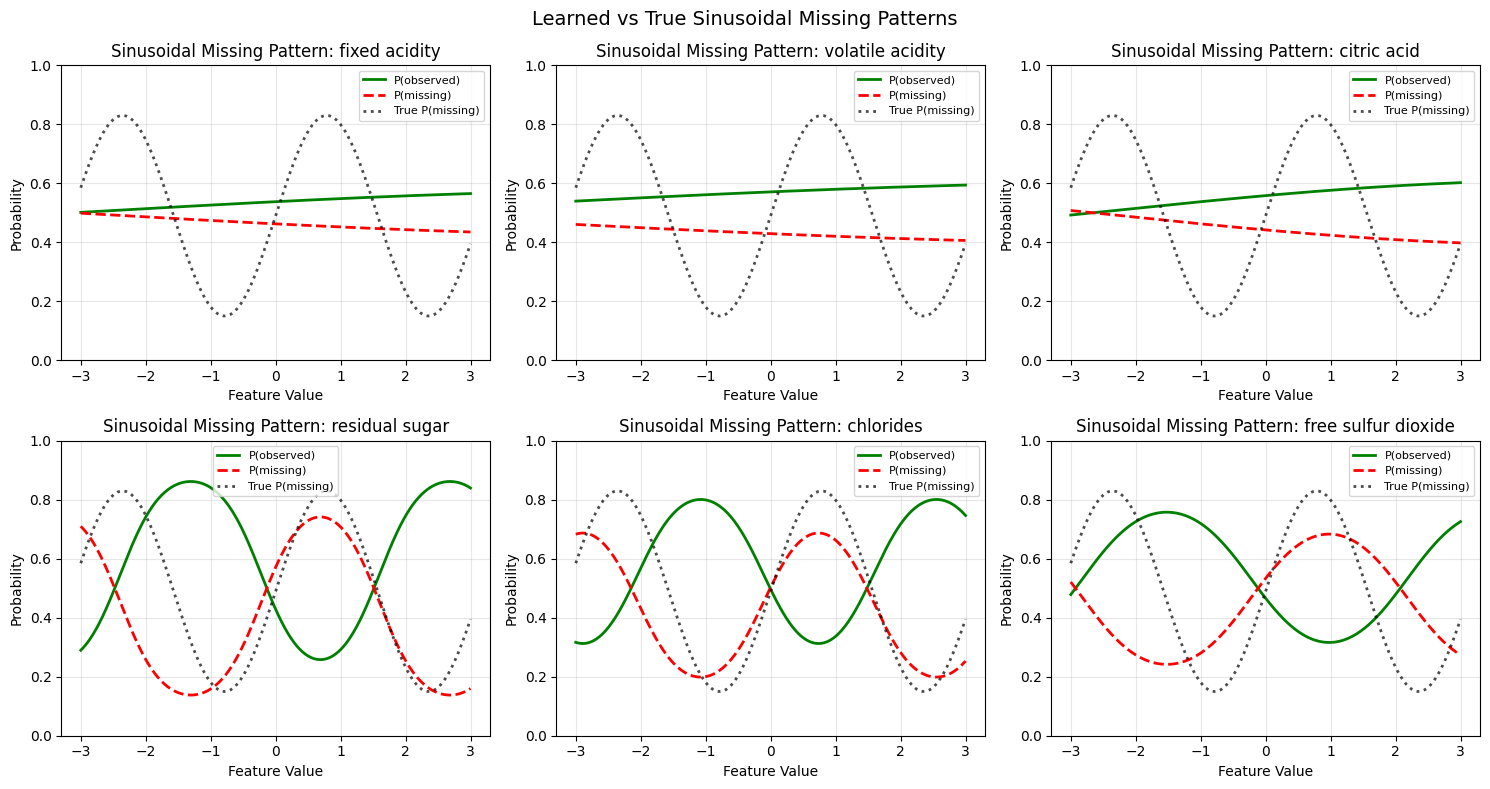

In [ ]:
# Visualize the learned missing probability curves
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i in range(min(6, D)):
    feature_name = data.columns[i]
    
    # Use actual data range for this feature
    x_min = X_std[:, i].min()
    x_max = X_std[:, i].max()
    x_range = (x_min, x_max)
    
    # Plot learned curve
    model_sin.missing_model.plot_missing_probability(feature_idx=i, x_range=x_range, ax=axes[i])
    
    # Overlay the true pattern
    x_vals = np.linspace(x_min, x_max, 500)
    sin_comp = np.sin(sin_params['frequencies'][i] * x_vals + sin_params['phases'][i])
    sin_norm = 0.5 * (1 + sin_comp)
    true_prob_missing = sin_params['base_prob'] + sin_params['amplitude'] * (1 - sin_params['base_prob']) * sin_norm
    axes[i].plot(x_vals, true_prob_missing, 'k:', linewidth=2.5, alpha=0.7, label='True P(missing)')
    axes[i].set_title(f'{feature_name}\nLearned vs True Missing Pattern')
    axes[i].legend(fontsize=8, loc='best')
    
    # Add text box with parameters
    true_freq = sin_params['frequencies'][i]
    learned_freq = results['interpretations'][i]['frequency']
    textstr = f'True f: {true_freq:.3f}\nLearned f: {learned_freq:.3f}'
    axes[i].text(0.02, 0.98, textstr, transform=axes[i].transAxes, fontsize=8,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Learned vs True Sinusoidal Missing Patterns (Raw Data Scale)', fontsize=14)
plt.tight_layout()
plt.show()

Imputation RMSE (missing values only): 0.8774


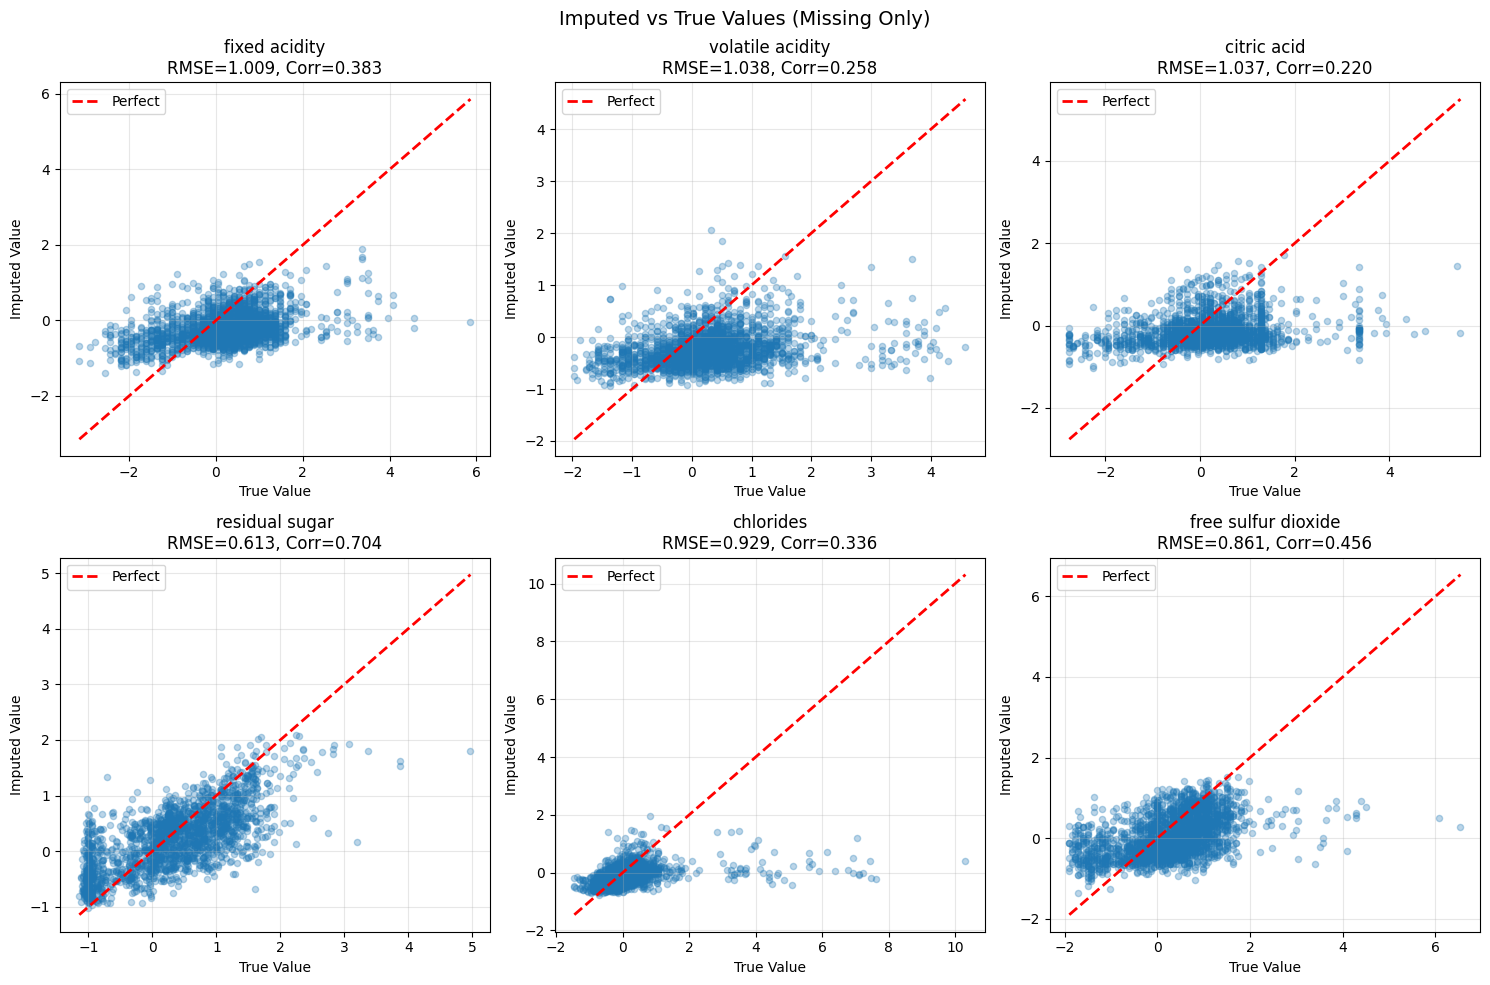

In [18]:
# Impute missing values and compare with true values
X_test = torch.tensor(X_filled_sin, dtype=torch.float32).to(device)
mask_test = torch.tensor(mask_sin, dtype=torch.float32).to(device)

# Get imputations
with torch.no_grad():
    X_imputed = model_sin.impute(X_test, mask_test, n_samples=50).cpu().numpy()

X_true = X_std  # Original complete data

# Calculate RMSE on missing values only
missing_mask = (mask_sin == 0)
rmse = np.sqrt(np.mean((X_imputed[missing_mask] - X_true[missing_mask])**2))
print(f"Imputation RMSE (missing values only): {rmse:.4f}")

# Visualize imputed vs true for a few features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(6, D)):
    ax = axes[i]
    feature_name = data.columns[i]
    
    # Get missing indices for this feature
    missing_idx = np.where(mask_sin[:, i] == 0)[0]
    
    if len(missing_idx) > 0:
        true_vals = X_true[missing_idx, i]
        imputed_vals = X_imputed[missing_idx, i]
        
        # Scatter plot: imputed vs true
        ax.scatter(true_vals, imputed_vals, alpha=0.3, s=20)
        
        # Perfect prediction line
        min_val = min(true_vals.min(), imputed_vals.min())
        max_val = max(true_vals.max(), imputed_vals.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
        
        # Calculate feature-specific RMSE
        feat_rmse = np.sqrt(np.mean((imputed_vals - true_vals)**2))
        corr = np.corrcoef(true_vals, imputed_vals)[0, 1]
        
        ax.set_xlabel('True Value')
        ax.set_ylabel('Imputed Value')
        ax.set_title(f'{feature_name}\nRMSE={feat_rmse:.3f}, Corr={corr:.3f}')
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)

plt.suptitle('Imputed vs True Values (Missing Only)', fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
# Compare with classical imputation methods
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Prepare data with NaN for sklearn imputers
X_with_nan = X_std.copy()
X_with_nan[mask_sin == 0] = np.nan

# Different imputation methods
imputers = {
    'Mean': SimpleImputer(strategy='mean'),
    'Median': SimpleImputer(strategy='median'),
    'KNN (k=5)': KNNImputer(n_neighbors=5),
    'MICE': IterativeImputer(max_iter=10, random_state=42),
    'Not-MIWAE (Sinusoidal)': None  # Already computed
}

imputation_results = {}

for name, imputer in imputers.items():
    if imputer is not None:
        X_imp = imputer.fit_transform(X_with_nan)
    else:
        X_imp = X_imputed  # Use already computed Not-MIWAE result
    
    # Calculate RMSE on missing values only
    rmse = np.sqrt(np.mean((X_imp[missing_mask] - X_true[missing_mask])**2))
    imputation_results[name] = {'imputed': X_imp, 'rmse': rmse}
    print(f"{name:25s} RMSE: {rmse:.4f}")

print("\n" + "="*50)
print(f"Best method: {min(imputation_results.items(), key=lambda x: x[1]['rmse'])[0]}")

Mean                      RMSE: 1.0484
Median                    RMSE: 1.1804
KNN (k=5)                 RMSE: 1.0629
MICE                      RMSE: 0.9330
Not-MIWAE (Sinusoidal)    RMSE: 0.8774

Best method: Not-MIWAE (Sinusoidal)


c:\Users\adamg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


c:\Users\adamg\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\adamg\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


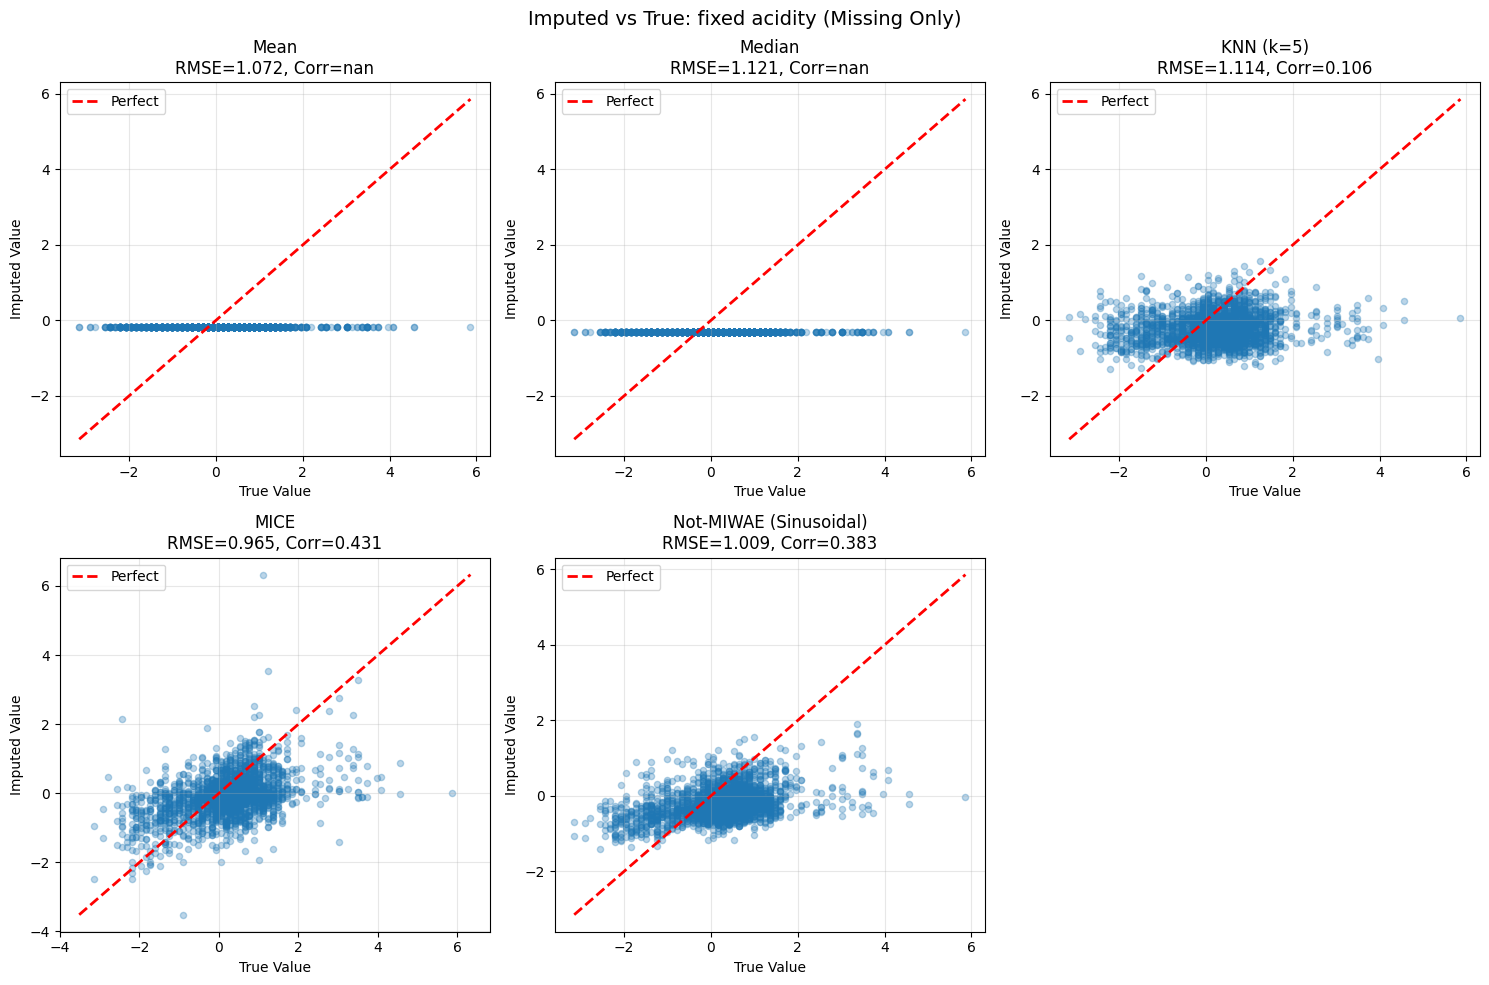

In [20]:
# Visualize imputed vs true for all methods (one feature)
feature_idx = 0
feature_name = data.columns[feature_idx]
missing_idx = np.where(mask_sin[:, feature_idx] == 0)[0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(imputation_results.items()):
    if idx >= 6:
        break
    ax = axes[idx]
    
    true_vals = X_true[missing_idx, feature_idx]
    imputed_vals = result['imputed'][missing_idx, feature_idx]
    
    # Scatter plot: imputed vs true
    ax.scatter(true_vals, imputed_vals, alpha=0.3, s=20)
    
    # Perfect prediction line
    min_val = min(true_vals.min(), imputed_vals.min())
    max_val = max(true_vals.max(), imputed_vals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
    
    # Calculate metrics
    feat_rmse = np.sqrt(np.mean((imputed_vals - true_vals)**2))
    corr = np.corrcoef(true_vals, imputed_vals)[0, 1]
    
    ax.set_xlabel('True Value')
    ax.set_ylabel('Imputed Value')
    ax.set_title(f'{name}\nRMSE={feat_rmse:.3f}, Corr={corr:.3f}')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(imputation_results), 6):
    axes[idx].set_visible(False)

plt.suptitle(f'Imputed vs True: {feature_name} (Missing Only)', fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\adamg\AppData\Local\Temp\ipykernel_17928\873240026.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=15, ha='right')


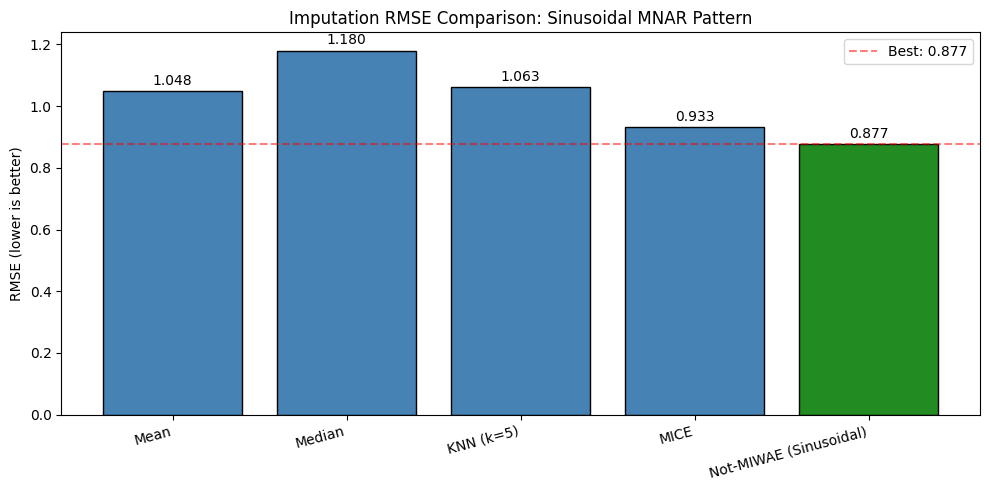


SUMMARY: Imputation Performance under Sinusoidal MNAR
Method                          RMSE  Improvement vs Mean
------------------------------------------------------------
Not-MIWAE (Sinusoidal)        0.8774                16.3%
MICE                          0.9330                11.0%
Mean                          1.0484                 0.0%
KNN (k=5)                     1.0629                -1.4%
Median                        1.1804               -12.6%


In [21]:
# Bar chart comparison of RMSE across all methods
fig, ax = plt.subplots(figsize=(10, 5))

methods = list(imputation_results.keys())
rmses = [imputation_results[m]['rmse'] for m in methods]
colors = ['steelblue'] * (len(methods) - 1) + ['forestgreen']  # Highlight Not-MIWAE

bars = ax.bar(methods, rmses, color=colors, edgecolor='black')
ax.set_ylabel('RMSE (lower is better)')
ax.set_title('Imputation RMSE Comparison: Sinusoidal MNAR Pattern')
ax.set_xticklabels(methods, rotation=15, ha='right')

# Add value labels on bars
for bar, rmse in zip(bars, rmses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{rmse:.3f}', ha='center', va='bottom', fontsize=10)

# Add horizontal line at best result
best_rmse = min(rmses)
ax.axhline(y=best_rmse, color='red', linestyle='--', alpha=0.5, label=f'Best: {best_rmse:.3f}')
ax.legend()

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*60)
print("SUMMARY: Imputation Performance under Sinusoidal MNAR")
print("="*60)
print(f"{'Method':<25} {'RMSE':>10} {'Improvement vs Mean':>20}")
print("-"*60)
mean_rmse = imputation_results['Mean']['rmse']
for name, result in sorted(imputation_results.items(), key=lambda x: x[1]['rmse']):
    improvement = (mean_rmse - result['rmse']) / mean_rmse * 100
    print(f"{name:<25} {result['rmse']:>10.4f} {improvement:>19.1f}%")